# English difficulty level evaluation
Watching movies in original language is a very popular and effective way to learn foreign language. It's important to choose a proper movie so student could understand 50-70% of dialogues. To fulfill this condition, the teacher must watch the film and decide which level it corresponds to. It requires much time and genre preferences of a student and a teacher may differ. 

The goal of this project is to develop an ML solution for automatically determining the level of complexity of English-language films.

Subtitles stored separately in srt files, labels stored in `labels.csv`

The main problem we have here is:
- too little sample with movies which can cause difficulties in training and testing model;
- different expert opinions led to the appearance of two different categories at once for some films;
- such qualitative features as prononciation quality and speech intelligibility weren't provided. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Splitting-data" data-toc-modified-id="Splitting-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Splitting data</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Baseline</a></span><ul class="toc-item"><li><span><a href="#Full-data" data-toc-modified-id="Full-data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Full data</a></span></li><li><span><a href="#Parts-data" data-toc-modified-id="Parts-data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Parts data</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysrt
import re
import os
import string
import spacy
import shap
from pdfminer.high_level import extract_text
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from statistics import mean, stdev

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
PTH = './Subtitles'

## Preprocessing

Collecting data to DataFrame:

In [3]:
def collecting_data(parts: int):
    """Collects data from srt files and splits files into parts. Returns DataFrame object."""
    df = []
    for el in os.scandir(PTH):
        if not el.name.endswith('.srt'):
            continue
# opening file
        sub = pysrt.open(el.path)
# splitting file into parts
        l5 = round(len(sub) / parts)
        for i in range(parts):
# recording movie name 
            name = el.name.split('.')[0]

            idx_start = i * l5
            idx_stop = (i + 1) * l5
            if i == (parts - 1):
                sub_part = pysrt.open(el.path)[idx_start : ]
            else:
                sub_part = pysrt.open(el.path)[idx_start : idx_stop]
# recording text 
            text = sub_part.text
# calculating part duration          
            movie_time = (sub_part[-1].end.ordinal - sub_part[0].start.ordinal) / 1000
# calculating subs duration
            sub_time = 0
            for item in sub_part:
                sub_time += (item.end.ordinal - item.start.ordinal) / 1000
# appending data to 'df'       
            df.append([name, text, sub_time, movie_time])
        
    return pd.DataFrame(data=df, columns=['label', 'text', 'sub_time', 'movie_time'])

In [4]:
def total_view(df: pd.DataFrame, n_rows=5, seed=42):
    '''Returns first, random and last 5 rows'''
    return display(pd.concat([df.head(n_rows),
                              df.sample(n_rows, random_state=seed),
                              df.tail(n_rows)]))

Full movies data will be in `subs_full`, splitted into parts data will be in `subs_parts`:

In [5]:
subs_full = collecting_data(1)
subs_parts = collecting_data(5)

print('subs_full shape:', subs_full.shape)
total_view(subs_full)

print('subs_parts shape:', subs_parts.shape)
total_view(subs_parts)

subs_full shape: (86, 4)


,label,text,sub_time,movie_time
0,Dredd(2012),America is an irradiated wasteIand.\nWithin it...,1933.923,5290.743
1,The_secret_life_of_Walter_Mitty(2013),"Huh?\nHi! Todd Mahar,\neHarmony.\nHow can I he...",3305.474,6688.762
2,Shrek(2001),anoXmous\nhttps://thepiratebay.se/user/Zen_Bud...,4436.597,5391.063
3,Deadpool(2016),<font color=#32a615><b>WordsKill</b></font>\n<...,3860.960,6480.818
4,We_are_the_Millers(2013),"<i>Oh, my God...</i>\n<i>...it's full-on doubl...",4973.566,7102.808
75,Dune(2021),[man speaks Sardaukar]\n[slow dramatic music p...,3412.719,8882.393
0,Dredd(2012),America is an irradiated wasteIand.\nWithin it...,1933.923,5290.743
70,Finding_Nemo(2003),[Music playing]\nAdvertise your product or bra...,4966.463,6102.376
22,All_dogs_go_to_heaven(1989),CAPTIONING MADE POSSIBLE BY\nMGM HOME ENTERTAI...,3735.979,4980.625
12,The_holiday(2006),I have found almost everything\never written a...,4249.400,7753.000


subs_parts shape: (430, 4)


,label,text,sub_time,movie_time
0,Dredd(2012),America is an irradiated wasteIand.\nWithin it...,411.429,895.686
1,Dredd(2012),l was born and raised in a block like this\nbe...,399.625,962.669
2,Dredd(2012),We're gonna hand these Judges\nback to Ma-Ma o...,390.570,1078.993
3,Dredd(2012),Can you hoId your current GPS?\nNegative.\nlf ...,377.144,932.139
4,Dredd(2012),-Are you prepared to testify to that?\n-Sure.\...,355.155,1419.834
422,Her(2013),"<i>THEODORE: God, I was just\nsomewhere else w...",911.092,1298.970
75,10_things_I_hate_about_you(1999),"Hey!\nI'll be right with you.\nSo, Cameron. He...",580.802,892.099
177,The_break-up(2006),"Lupus, I got to be totally...\nI got to be hon...",757.500,906.200
30,Babe(1995),This is a tale about<br/>an unprejudiced heart...,521.645,811.473
361,The_kings_speech(2010),- Don't be ridiculous.<br/>- How about when yo...,812.510,1316.070


Movie titles and English difficulty levels stored in `labels`:

In [6]:
labels = pd.read_csv('labels.csv').rename(columns={'Movie':'label', 'Level':'target'})
total_view(labels)
labels.shape

,label,Kinopoisk,target,Subtitles
0,Forrest Gump,Rus sub,"A2/A2+, B1",Yes
1,Finding Nemo\n,Everything,A2/A2+,Yes
2,Cast away\n,"Paid, Rus sub",A2/A2+,Yes
3,The invisible man (2020)\n,"Paid, Rus lan",A2/A2+,Yes
4,Back to the future\n,Rus sub,A2/A2+,Yes
76,Logan,NaN,B1,Yes
0,Forrest Gump,Rus sub,"A2/A2+, B1",Yes
26,Harry Potter (1),Rus sub,B1,Yes
22,The lion king,Everything,A2/A2+,Yes
12,The terminal\n,Rus sub,"A2/A2+, B1",Yes


(88, 4)

Next step is dropping `Lie to me (series)` and `The Walking Dead (series)🧟` from `labels` (because we can't compare a movie and series for many reasons such as too much difference in duration berween movie and series and difficulty levels between series) and clearing data in both 'label' columns to merge tables.

In [7]:
labels = labels.drop([58, 83])

In [8]:
def label_correction(row):
    '''Returns lowercase string without punktuation marks, emoji, extra spaces and text in parenthesis'''
    return re.sub(r'[^a-zA-Z ]+', '', (re.sub('\((.*?)\)', '', re.sub('_', ' ', row['label']))
                                                                 .replace('’', ' ')
                                                                 .replace('  ', ' ')
                                                                 .lower())) \
             .strip(string.whitespace)

subs_full['label'] = subs_full.apply(label_correction, axis=1)
subs_parts['label'] = subs_parts.apply(label_correction, axis=1)
labels['label'] = labels.apply(label_correction, axis=1)

Here we have slight differences in titles between the same movies. Renaming movie titles:

In [9]:
corr_dict = {'a knight s tale': 'a knights tale',
             'eurovision song contest the story of fire saga': 'eurovision song contest',
             'harry potter': 'harry potter and the philosophers stone',
             'the king s speech': 'the kings speech',
             'the man called flinstone': 'the man called flintstone',
             'we re the millers': 'we are the millers'}

labels['label'] = labels['label'].map(lambda x: corr_dict.get(x, x))

Some movies have two english difficulty levels due to different expert opinions. It's better to assign them the higher of two levels.

In [10]:
labels['target'].value_counts()

B1            28
A2/A2+        26
B2            19
B1, B2         8
A2/A2+, B1     5
Name: target, dtype: int64

In [11]:
corr_target = {'A2/A2+, B1': 'B1',
               'B1, B2': 'B2'}
labels['target'] = labels['target'].map(lambda x: corr_target.get(x, x))

Merging tables:

In [12]:
subs_full = subs_full.merge(labels[['label', 'target']], on='label', how='left')
subs_parts = subs_parts.merge(labels[['label', 'target']], on='label', how='left')

Before we can do anything with text we need to edit it. This text editing function returns edited text - witout tags, punctuation marks, extra spaces and so on:

In [13]:
def text_editing(row):
    '''Returns edited text'''
    t = re.sub('\n', ' ', row['text'])
    t = re.sub('<(.*?)>', ' ', t)
    t = (re.sub('\((.*?)\)', ' ', t)
        .replace('let\'s', 'let us')
        .replace('\'s', '')
        .replace('\'m', '')
        .replace('won\'t', 'will not')
        .replace('don\'t', 'do not')
        .replace('\'ve', '')
        .replace('\'t', '')
        .replace('\'re', '')
        .replace('\'d', '')
        .replace('\'ll', '')
        .replace('\'em', 'them')
        .replace('in\'', 'ing')
        .replace('-', ' ')
        )
    t = re.sub('[^a-zA-Z ]', '', t).lower()
    t = re.sub(' +', ' ', t).strip(' ')
    return t

subs_full['text'] = subs_full.apply(text_editing, axis=1)
subs_parts['text'] = subs_parts.apply(text_editing, axis=1)

## Feature engineering

Now we need to lemmatize text so we can make feature engineering:

In [14]:
en = spacy.load('en_core_web_sm')

def spacy_lemmas(row):
    '''Returns lemmas of given string'''
    return [token.lemma_ for token in en(row['text'])]

subs_full['lemmas'] = subs_full.apply(spacy_lemmas, axis=1)
subs_parts['lemmas'] = subs_parts.apply(spacy_lemmas, axis=1)

In [15]:
# words counting
def total_words(row):
    return len(row['lemmas'])

subs_full['total_words'] = subs_full.apply(total_words, axis=1)
subs_parts['total_words'] = subs_parts.apply(total_words, axis=1)

In [16]:
# unique words counting
def unique_words(row):
    return len(set(row['lemmas']))

subs_full['unique_words'] = subs_full.apply(unique_words, axis=1)
subs_parts['unique_words'] = subs_parts.apply(unique_words, axis=1)

In [17]:
# text length
subs_full['str_len'] = subs_full['text'].str.len()
subs_parts['str_len'] = subs_parts['text'].str.len()

# average word length
subs_full['avg_word_length'] = subs_full['str_len'] / subs_full['total_words']
subs_parts['avg_word_length'] = subs_parts['str_len'] / subs_parts['total_words']

In [18]:
# words per second in movie
subs_full['speech_speed'] = subs_full['total_words'] / subs_full['movie_time']
subs_parts['speech_speed'] = subs_parts['total_words'] / subs_parts['movie_time']

# word per second in subtitles
subs_full['subs_speed'] = subs_full['total_words'] / subs_full['sub_time']
subs_parts['subs_speed'] = subs_parts['total_words'] / subs_parts['sub_time']

# subtitles/movie share
subs_full['subs_share'] = subs_full['sub_time'] / subs_full['movie_time']
subs_parts['subs_share'] = subs_parts['sub_time'] / subs_parts['movie_time']

For next features I used Oxford's 5000-word list (https://www.oxfordlearnersdictionaries.com/wordlists/oxford3000-5000). It contains English difficulty levels witch makes it easy to count the words share for each difficulty level.

In [19]:
ab_text = extract_text('The_Oxford_3000.pdf')
ab_list = ab_text.split('\n')

bc_text = extract_text('The_Oxford_5000.pdf')
bc_list = bc_text.split('\n')[5:-8]

In [20]:
words_dict = {}

def oxford_5000(text_list):
    '''Adds words as keys and levels as values to words_dict dictionary'''
    filtered_words = [x for x in text_list if (x != '') and ('oxford' not in x.lower())
                                                        and (re.search('[a-zA-Z]', x))]

    for x in filtered_words:
        x = re.sub('\xa0', ' ', x)
        x = re.sub('\x0c', ' ', x)
        x = re.sub('[.,]', ' ', x)
        x = re.sub('[^a-zA-Z0-9 ]', '', x).strip(' ').lower()
        key = re.sub('[1]', '', x.split(' ')[0])
        value = x.split(' ')[-1]
        words_dict[key] = value
        
oxford_5000(ab_list)
oxford_5000(bc_list)

In [21]:
def count_words(row):
    '''Returns calculated amount of words for each level'''
    cnt_A = 0
    cnt_B1 = 0
    cnt_B2 = 0
    cnt_C = 0
    cnt_other = 0
    for word in row['lemmas']:
        if (words_dict.get(word) == 'a1') or (words_dict.get(word) == 'a2'):
            cnt_A += 1
        elif words_dict.get(word) == 'b1':
            cnt_B1 += 1
        elif words_dict.get(word) == 'b2':
            cnt_B2 += 1
        elif words_dict.get(word) == 'c1':
            cnt_C += 1    
        else:
            cnt_other += 1
    
    return pd.Series([cnt_A, cnt_B1, cnt_B2, cnt_C, cnt_other])

subs_full[['a', 'b1', 'b2', 'c', 'other']] = subs_full.apply(count_words, axis=1)
subs_parts[['a', 'b1', 'b2', 'c', 'other']] = subs_parts.apply(count_words, axis=1)

In [22]:
subs_full['a_share'] = subs_full['a'] / subs_full['total_words']
subs_full['b1_share'] = (subs_full['a'] + subs_full['b1']) / subs_full['total_words']
subs_full['b2_share'] = (subs_full['a'] + subs_full['b1'] + subs_full['b2']) / subs_full['total_words']
subs_full['c_share'] = (subs_full['a'] + subs_full['b1'] + subs_full['b2'] + subs_full['c']) \
                       / subs_full['total_words']

subs_parts['a_share'] = subs_parts['a'] / subs_parts['total_words']
subs_parts['b1_share'] = (subs_parts['a'] + subs_parts['b1']) / subs_parts['total_words']
subs_parts['b2_share'] = (subs_parts['a'] + subs_parts['b1'] + subs_parts['b2']) / subs_parts['total_words']
subs_parts['c_share'] = (subs_parts['a'] + subs_parts['b1'] + subs_parts['b2'] + subs_parts['c']) \
                        / subs_parts['total_words']

In [23]:
total_view(subs_full)
total_view(subs_parts)

,label,text,sub_time,movie_time,target,lemmas,total_words,unique_words,str_len,avg_word_length,speech_speed,subs_speed,subs_share,a,b1,b2,c,other,a_share,b1_share,b2_share,c_share
0,dredd,america is an irradiated wasteiand within it l...,1933.923,5290.743,A2/A2+,"[america, be, an, irradiated, wasteiand, withi...",5003,1001,25312,5.059364,0.945614,2.586970,0.365530,3260,441,363,158,781,0.651609,0.739756,0.812313,0.843894
1,the secret life of walter mitty,huh hi todd mahar eharmony how can i help you ...,3305.474,6688.762,B1,"[huh, hi, todd, mahar, eharmony, how, can, I, ...",8629,1222,41682,4.830455,1.290074,2.610518,0.494183,6072,690,415,181,1271,0.703674,0.783637,0.831730,0.852706
2,shrek,anoxmous httpsthepiratebayseuserzenbud once up...,4436.597,5391.063,B1,"[anoxmous, httpsthepiratebayseuserzenbud, once...",9950,1356,48224,4.846633,1.845647,2.242710,0.822954,6542,786,485,283,1854,0.657487,0.736482,0.785226,0.813668
3,deadpool,wordskill edited by ahmedhamdy subscenecom ahm...,3860.960,6480.818,B2,"[wordskill, edit, by, ahmedhamdy, subscenecom,...",8931,1686,44162,4.944799,1.378067,2.313155,0.595752,5739,739,509,242,1702,0.642593,0.725339,0.782331,0.809428
4,we are the millers,oh my god it full on double rainbow all the wa...,4973.566,7102.808,B1,"[oh, my, god, it, full, on, double, rainbow, a...",15165,1761,71389,4.707484,2.135071,3.049120,0.700225,10211,1195,662,383,2714,0.673327,0.752127,0.795780,0.821035
75,dune,man speaks sardaukar slow dramatic music playi...,3412.719,8882.393,B2,"[man, speak, sardaukar, slow, dramatic, music,...",7889,1417,42808,5.426290,0.888162,2.311647,0.384212,4867,623,506,176,1717,0.616935,0.695906,0.760046,0.782355
0,dredd,america is an irradiated wasteiand within it l...,1933.923,5290.743,A2/A2+,"[america, be, an, irradiated, wasteiand, withi...",5003,1001,25312,5.059364,0.945614,2.586970,0.365530,3260,441,363,158,781,0.651609,0.739756,0.812313,0.843894
70,finding nemo,music playing advertise your product or brand ...,4966.463,6102.376,A2/A2+,"[music, playing, advertise, your, product, or,...",11287,1406,54146,4.797200,1.849607,2.272644,0.813857,7184,865,459,247,2532,0.636484,0.713121,0.753788,0.775671
22,all dogs go to heaven,captioning made possible by mgm home entertain...,3735.979,4980.625,A2/A2+,"[captioning, make, possible, by, mgm, home, en...",8201,1128,38177,4.655164,1.646580,2.195141,0.750102,5135,561,391,161,1953,0.626143,0.694549,0.742227,0.761858
12,the holiday,i have found almost everything ever written ab...,4249.400,7753.000,B1,"[I, have, find, almost, everything, ever, writ...",11606,1402,55910,4.817336,1.496969,2.731209,0.548098,8099,892,579,293,1743,0.697829,0.774686,0.824573,0.849819


,label,text,sub_time,movie_time,target,lemmas,total_words,unique_words,str_len,avg_word_length,speech_speed,subs_speed,subs_share,a,b1,b2,c,other,a_share,b1_share,b2_share,c_share
0,dredd,america is an irradiated wasteiand within it l...,411.429,895.686,A2/A2+,"[america, be, an, irradiated, wasteiand, withi...",1021,434,5517,5.403526,1.139908,2.481595,0.459345,653,74,83,31,180,0.639569,0.712047,0.793340,0.823702
1,dredd,l was born and raised in a block like this bef...,399.625,962.669,A2/A2+,"[l, be, bear, and, raise, in, a, block, like, ...",1039,415,5352,5.151107,1.079291,2.599937,0.415122,666,93,83,30,167,0.641001,0.730510,0.810395,0.839269
2,dredd,we gonna hand these judges back to ma ma on a ...,390.570,1078.993,A2/A2+,"[we, go, to, hand, these, judge, back, to, ma,...",1013,360,5029,4.964462,0.938838,2.593645,0.361976,681,103,77,31,121,0.672261,0.773939,0.849951,0.880553
3,dredd,can you hoid your current gps negative lf they...,377.144,932.139,A2/A2+,"[can, you, hoid, your, current, gps, negative,...",1028,361,5066,4.928016,1.102840,2.725749,0.404601,654,101,57,38,178,0.636187,0.734436,0.789883,0.826848
4,dredd,are you prepared to testify to that sure one m...,355.155,1419.834,A2/A2+,"[be, you, prepared, to, testify, to, that, sur...",902,328,4344,4.815965,0.635286,2.539736,0.250138,606,70,63,28,135,0.671840,0.749446,0.819290,0.850333
422,her,theodore god i was just somewhere else with yo...,911.092,1298.970,B1,"[theodore, god, I, be, just, somewhere, else, ...",2466,511,11934,4.839416,1.898427,2.706642,0.701396,1669,144,121,72,460,0.676805,0.735199,0.784266,0.813463
75,things i hate about you,hey i be right with you so cameron here you go...,580.802,892.099,B1,"[hey, I, be, right, with, you, so, cameron, he...",1670,566,8416,5.039521,1.871990,2.875334,0.651051,1109,125,99,33,304,0.664072,0.738922,0.798204,0.817964
177,the breakup,lupus i got to be totally i got to be honest w...,757.500,906.200,A2/A2+,"[lupus, I, get, to, be, totally, I, get, to, b...",3056,685,14791,4.839987,3.372324,4.034323,0.835908,2162,256,147,61,430,0.707461,0.791230,0.839332,0.859293
30,babe,this is a tale about an unprejudiced heart and...,521.645,811.473,A2/A2+,"[this, be, a, tale, about, an, unprejudiced, h...",1262,410,6078,4.816165,1.555197,2.419270,0.642837,934,79,50,21,178,0.740095,0.802694,0.842314,0.858954
361,the kings speech,don be ridiculous how about when you talk to y...,812.510,1316.070,B2,"[don, be, ridiculous, how, about, when, you, t...",1903,643,9826,5.163426,1.445972,2.342125,0.617376,1247,148,112,52,344,0.655281,0.733053,0.791908,0.819233


## Splitting data

In [24]:
# features list
train_columns = ['sub_time',
                 'movie_time',
                 'total_words',
                 'unique_words',
                 'str_len', 
                 'avg_word_length', 
                 'speech_speed',
                 'subs_speed',
                 'subs_share',
                 'a',
                 'b1',
                 'b2',
                 'c',
                 'other',
                 'a_share',
                 'b1_share',
                 'b2_share',
                 'c_share'
                ]

In [25]:
x_full = subs_full[train_columns]
y_full = subs_full['target']

x_parts = subs_parts[train_columns]
y_parts = subs_parts['target']

In [26]:
# full
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_full,
                                                                        y_full,
                                                                        stratify=subs_full['target'],
                                                                        test_size=0.20,
                                                                        random_state=42)

In [27]:
# parts
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x_parts,
                                                            y_parts,
                                                            test_size=0.20,
                                                            stratify=subs_parts['target'],
                                                            random_state=42)

## Baseline

### Full data

Training model with full data at first:

In [28]:
model_cb = CatBoostClassifier(random_state=42,
                              verbose=False,
                              loss_function='MultiClass'
                             )

pool_train = Pool(data=x_train_full, label=y_train_full)
model_cb.fit(pool_train)
predictions = model_cb.predict(x_test_full)
print(classification_report(y_test_full, predictions))

              precision    recall  f1-score   support

      A2/A2+       0.40      0.40      0.40         5
          B1       0.67      0.86      0.75         7
          B2       0.75      0.50      0.60         6

    accuracy                           0.61        18
   macro avg       0.61      0.59      0.58        18
weighted avg       0.62      0.61      0.60        18



Let's look at shap values:

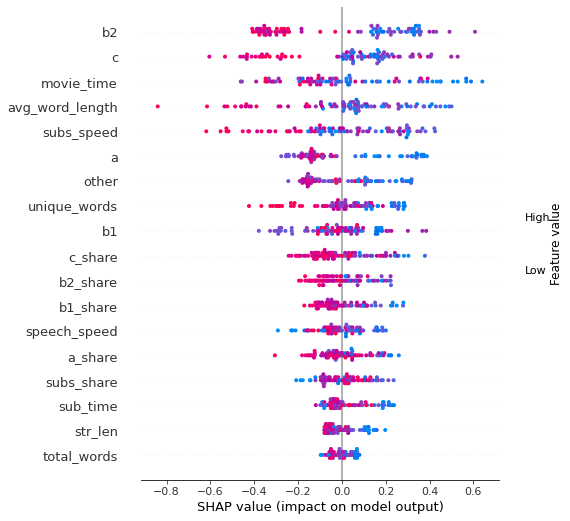

In [29]:
explainer = shap.TreeExplainer(model_cb)
pool_train = Pool(data=x_full, label=y_full)
shap_values = explainer.shap_values(pool_train)

# A2/A2+
shap.summary_plot(shap_values[0], x_full)

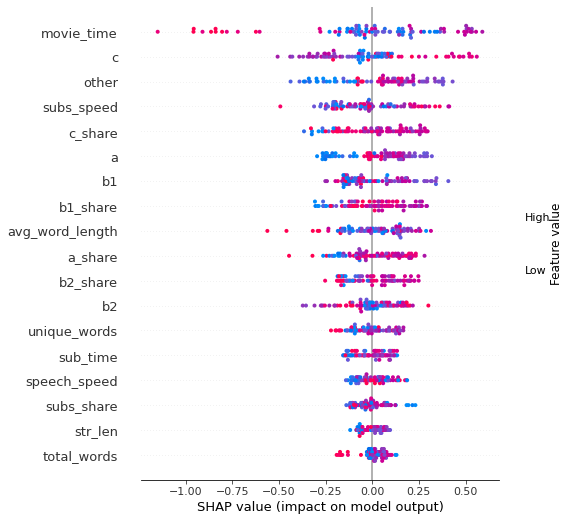

In [30]:
# B1
shap.summary_plot(shap_values[1], x_full)

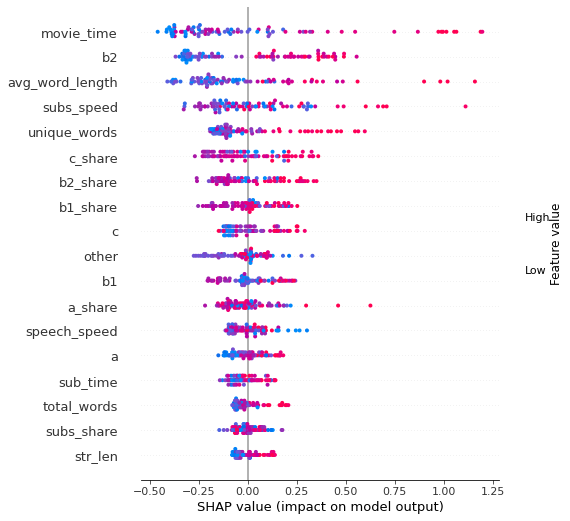

In [31]:
# B2
shap.summary_plot(shap_values[2], x_full)

The following features have the greatest impact:
* movie_time - the longer movie - the harder the English;
* avg_word_length - the shortet average word length - the simplier the English;
* b2 - the more amount of b2-level words - the harder the English;
* unique_words - the more unique words in the movie - the harder the English;
* subs_speed - the more subs speed (words per second shown) - he harder the English.

Due to lack of data the accuracy measurment is very low quality. It depends on random state and train/test size a lot: the more data in train gives the better model but we can't evaluate it properly because we don't have enough data in test. On the other hand the more data in test gives more accurate evaluation of model but in this way we receive poorly trained model because of lack of training data. Let's try to calculate accuracy on a stratified cross-validation:

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

accuracy = []

model_cb = CatBoostClassifier(random_state=42,
                              verbose=False,
                              loss_function='MultiClass')

for train_index, test_index in skf.split(x_full, y_full):
    x_train_fold, x_test_fold = x_full.loc[train_index], x_full.loc[test_index]
    y_train_fold, y_test_fold = y_full[train_index], y_full[test_index]
    model_cb.fit(x_train_fold, y_train_fold)
    accuracy.append(model_cb.score(x_test_fold, y_test_fold))

print(f'List of possible accuracy: {np.round(accuracy, 2)}')
print(f'Maximum Accuracy That can be obtained from this model is: {np.round(max(accuracy), 2)}')
print(f'Minimum Accuracy: {np.round(min(accuracy), 2)}')
print(f'Average Accuracy: {np.round(mean(accuracy), 2)}')
print(f'Standard Deviation is: {np.round(stdev(accuracy), 3)}')

List of possible accuracy: [0.5  0.47 0.59 0.41 0.59]
Maximum Accuracy That can be obtained from this model is: 0.59
Minimum Accuracy: 0.41
Average Accuracy: 0.51
Standard Deviation is: 0.077


Average accuracy is 0.51. It's lower than accuracy from classification report (0.61) but this evaluation of model is more accurate.

### Parts data

Training model with parts data:

In [33]:
model_cb = CatBoostClassifier(random_state=42,
                              verbose=False,
                              loss_function='MultiClass'
                             )

pool_train = Pool(data=x_train_p, label=y_train_p)
model_cb.fit(pool_train)
predictions = model_cb.predict(x_test_p)
print(classification_report(y_test_p, predictions))

              precision    recall  f1-score   support

      A2/A2+       0.85      0.65      0.74        26
          B1       0.69      0.76      0.72        33
          B2       0.53      0.59      0.56        27

    accuracy                           0.67        86
   macro avg       0.69      0.67      0.68        86
weighted avg       0.69      0.67      0.68        86



Shap values:

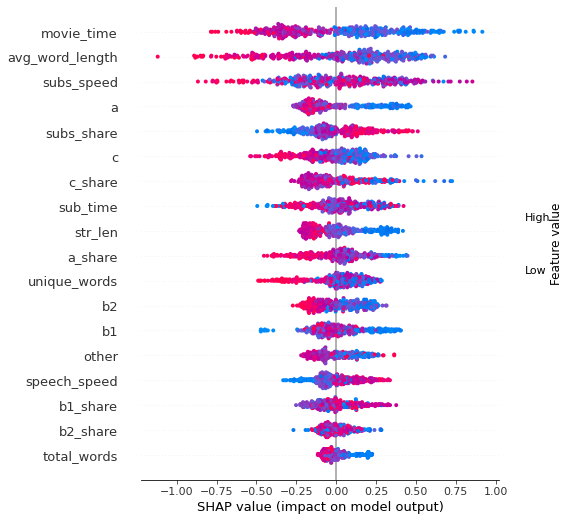

In [34]:
explainer = shap.TreeExplainer(model_cb)
pool_train = Pool(data=x_parts, label=y_parts)
shap_values = explainer.shap_values(pool_train)

# A2/A2+
shap.summary_plot(shap_values[0], x_parts)

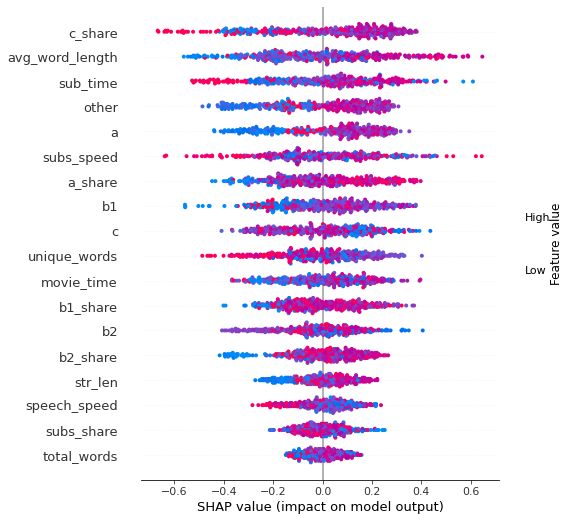

In [35]:
# B1
shap.summary_plot(shap_values[1], x_parts)

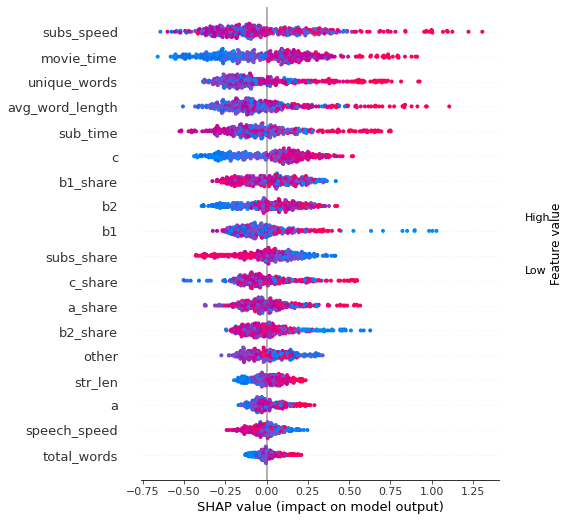

In [36]:
# B2
shap.summary_plot(shap_values[2], x_parts)

Main features here almost the same - movie_time, subs_speed, unique_words, avg_word_lenght.

Stratified cross-validatition:

In [37]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

accuracy = []

model_cb = CatBoostClassifier(random_state=42,
                              verbose=False,
                              loss_function='MultiClass')

for train_index, test_index in skf.split(x_parts, y_parts):
    x_train_fold, x_test_fold = x_parts.loc[train_index], x_parts.loc[test_index]
    y_train_fold, y_test_fold = y_parts[train_index], y_parts[test_index]
    model_cb.fit(x_train_fold, y_train_fold)
    accuracy.append(model_cb.score(x_test_fold, y_test_fold))

print(f'List of possible accuracy: {np.round(accuracy, 2)}')
print(f'Maximum Accuracy That can be obtained from this model is: {np.round(max(accuracy), 2)}')
print(f'Minimum Accuracy: {np.round(min(accuracy), 2)}')
print(f'Average Accuracy: {np.round(mean(accuracy), 2)}')
print(f'Standard Deviation is: {np.round(stdev(accuracy), 3)}')

List of possible accuracy: [0.52 0.65 0.65 0.59 0.62]
Maximum Accuracy That can be obtained from this model is: 0.65
Minimum Accuracy: 0.52
Average Accuracy: 0.61
Standard Deviation is: 0.053


An average accuracy is 0.61. It's higher than accuracy of model trained on full movie data because of data leakage. This happend because each movie have it's own style - amount of dialodues, speech speed, duration, main topic which implies specific words. After dividing movies into parts and splitting dataframe into train and test - many parts from the same movies turned out to be in both train and test samples.

## Conclusion

* The most realistic evaluation of model is 0.51 Accuracy.
* Dividing movies into parts helps to upsample. But in this way we receive a data leak. 
* Calculating features such as counting unique words, movie time, the amount of different difficulty levels words and so on can give good results. The main problem we have here is the lack of data and such qualitative features as prononciation quality and speech intelligibility which could have a strong influence on English difficulty level. 
* More data and expert information about prononciation quality and speech intelligibility could improve the results.